In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
import seaborn as sns
import datetime as dt
import matplotlib.font_manager as fm
import random
import holidays
import itertools

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
from plotnine import *
from pathlib import Path
from matplotlib import gridspec
from scipy import stats

import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px


In [2]:
fm.get_fontconfig_fonts()
font_location = 'C:\\WINDOWS\\Fonts\\malgun.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\2582751676.py:1: MatplotlibDeprecationWarning:


The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.



In [3]:
FILES_DIR = '../files/'
log_df = pd.read_csv(FILES_DIR + 'log_csv.csv')
bidding_df = pd.read_csv(FILES_DIR + 'bidding_results.csv')

In [4]:
log = log_df.copy()
bidding = bidding_df.copy()

In [5]:
# 서울과 경기도는 시, 구와 중복 데이터이기 때문에 drop한다
log_null_ts = log.copy()
drop_city = log_null_ts[log_null_ts['geoip_city_name'] != 'Seoul']
drop_city = drop_city[drop_city['geoip_city_name'] != 'Gyeonggi-do']

drop_city.isnull().sum().sort_values(ascending=False)

category3          643126
geoip_city_name    417032
uid                132162
viewrate             1722
Unnamed: 0              0
action_type             0
category1               0
category2               0
collect_time            0
useragent_os            0
viewtime                0
dtype: int64

In [6]:
# null값들을 un_** 으로 채워서 확인해보기
log_drop_null = drop_city
log_drop_null['geoip_city_name'].fillna('un_city_name', inplace = True)
log_drop_null['category3'].fillna('un_category', inplace = True)
log_drop_null['uid'].fillna('un_name', inplace = True)
log_drop_null.dropna(axis = 0, inplace = True)
print(log_drop_null.isnull().sum().sort_values(ascending=False)) # null값 퍼센트로 표현

Unnamed: 0         0
uid                0
action_type        0
category1          0
category2          0
category3          0
collect_time       0
geoip_city_name    0
useragent_os       0
viewrate           0
viewtime           0
dtype: int64


In [7]:
log_drop_null

,Unnamed: 0,uid,action_type,category1,category2,category3,collect_time,geoip_city_name,useragent_os,viewrate,viewtime
0,0,avpKyWMn/xEADNlb,View,주방용품,그릇·홈세트,식판·나눔접시,2022-12-29 17:29:02,Seongnam-si,Windows,100.0,80033
1,1,0+5vEmGkOuAAB5j2,Basket,패브릭,매트,주방·다용도매트,2022-12-29 12:56:38,Yongin-si,Windows,0.0,0
3,3,dC9Fl2Ly9lcADrTn,Highlight,데코·식물,플라워·식물,화병·화분,2022-12-29 17:54:30,Gwangmyeong-si,Windows,0.0,0
4,4,09gKcGLg0I8ACyQy,View,가구,진열장·책장,책장,2022-12-29 18:45:05,Jongno-gu,Mac OS X,100.0,1238
5,5,091fXGIDYFEABcpA,Basket,수납·정리,화장대·테이블정리,티슈커버·케이스,2022-12-29 17:53:11,Incheon,Windows,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
5659533,5659533,3yfy5mOZpbYAAMpw,View,가전·디지털,주방가전,오븐·전자레인지,2022-12-29 12:45:14,Gangnam-gu,Android,100.0,6054
5659534,5659534,qE73wWOr1C8ABhBw,View,캠핑용품,캠핑생활용품,기타캠핑생활용품,2022-12-28 15:40:29,Songpa-gu,Windows,100.0,10006
5659537,5659537,PVMstmNg4I4ADq9R,Basket,가구,진열장·책장,책장,2022-12-28 14:30:09,Jinju,Windows,0.0,0
5659538,5659538,diRXdmN49dUABrVo,View,가구,테이블·식탁·책상,식탁,2022-12-29 12:45:13,Gunpo,Android,100.0,47217


In [8]:
# 날짜 데이터 데이트타임으로 바꾸기
def _trans_date_time(log):
    log.index = pd.to_datetime(log['collect_time'], infer_datetime_format=True)
    log.drop('collect_time', axis=1, inplace=True)
    return log

_trans_date_time(log_drop_null)

,Unnamed: 0,uid,action_type,category1,category2,category3,geoip_city_name,useragent_os,viewrate,viewtime
collect_time,,,,,,,,,,
2022-12-29 17:29:02,0,avpKyWMn/xEADNlb,View,주방용품,그릇·홈세트,식판·나눔접시,Seongnam-si,Windows,100.0,80033
2022-12-29 12:56:38,1,0+5vEmGkOuAAB5j2,Basket,패브릭,매트,주방·다용도매트,Yongin-si,Windows,0.0,0
2022-12-29 17:54:30,3,dC9Fl2Ly9lcADrTn,Highlight,데코·식물,플라워·식물,화병·화분,Gwangmyeong-si,Windows,0.0,0
2022-12-29 18:45:05,4,09gKcGLg0I8ACyQy,View,가구,진열장·책장,책장,Jongno-gu,Mac OS X,100.0,1238
2022-12-29 17:53:11,5,091fXGIDYFEABcpA,Basket,수납·정리,화장대·테이블정리,티슈커버·케이스,Incheon,Windows,0.0,0
...,...,...,...,...,...,...,...,...,...,...
2022-12-29 12:45:14,5659533,3yfy5mOZpbYAAMpw,View,가전·디지털,주방가전,오븐·전자레인지,Gangnam-gu,Android,100.0,6054
2022-12-28 15:40:29,5659534,qE73wWOr1C8ABhBw,View,캠핑용품,캠핑생활용품,기타캠핑생활용품,Songpa-gu,Windows,100.0,10006
2022-12-28 14:30:09,5659537,PVMstmNg4I4ADq9R,Basket,가구,진열장·책장,책장,Jinju,Windows,0.0,0


In [9]:
log_drop_null["Hour"] = log_drop_null.index.hour
log_drop_null['Minute'] = log_drop_null.index.minute

In [10]:
basket_hour = log_drop_null.loc[log_drop_null['action_type'] == 'Basket']

log_drop_null['time_1'] = np.where((log_drop_null['Hour'] >= 10)&(log_drop_null["Hour"].values <= 17) , "1","0" )
log_time1 = log_drop_null.loc[log_drop_null["time_1"] == "1"]
# log_time1['useragent_os'].value_counts(normalize=True)

log_drop_null['time_2'] = np.where((log_drop_null['Hour'] >= 21) , "1","0" )
log_time2 = log_drop_null.loc[log_drop_null["time_2"] == "1"]
# log_time2['useragent_os'].value_counts(normalize=True)

basket_hour["time_1"] = np.where((basket_hour['Hour'] >= 10)&(basket_hour["Hour"].values <= 17) , "1","0" )
basket_time1 = basket_hour.loc[basket_hour["time_1"] == "1"]
# basket_time1['useragent_os'].value_counts(normalize=True)

basket_hour["time_2"] = np.where((basket_hour['Hour'] >= 21) , "1","0" )
basket_time2 = basket_hour.loc[basket_hour["time_2"] == "1"]
# basket_time2['useragent_os'].value_counts(normalize=True)

non_basket_hour = log_drop_null.loc[log_drop_null['action_type'] != 'Basket']

non_basket_hour["time_1"] = np.where((non_basket_hour['Hour'] >= 10)&(non_basket_hour["Hour"].values <= 17) , "1","0" )
non_basket_time1 = non_basket_hour.loc[non_basket_hour["time_1"] == "1"]
# non_basket_time1['useragent_os'].value_counts(normalize=True)

non_basket_hour["time_2"] = np.where((non_basket_hour['Hour'] >= 21) , "1","0" )
non_basket_time2 = non_basket_hour.loc[non_basket_hour["time_2"] == "1"]
# non_basket_time2['useragent_os'].value_counts(normalize=True)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\3789756027.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\3789756027.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\3789756027.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [11]:
sns.set_style("white")

# 그래프

13    0.077159
15    0.074382
14    0.071978
16    0.071233
11    0.070886
10    0.066830
17    0.059309
12    0.051725
9     0.051224
22    0.050619
21    0.045957
23    0.043812
0     0.041548
20    0.039981
18    0.036596
19    0.035117
1     0.026397
8     0.021371
2     0.018432
3     0.011777
7     0.010677
4     0.008309
6     0.007543
5     0.007138
Name: Hour, dtype: float64

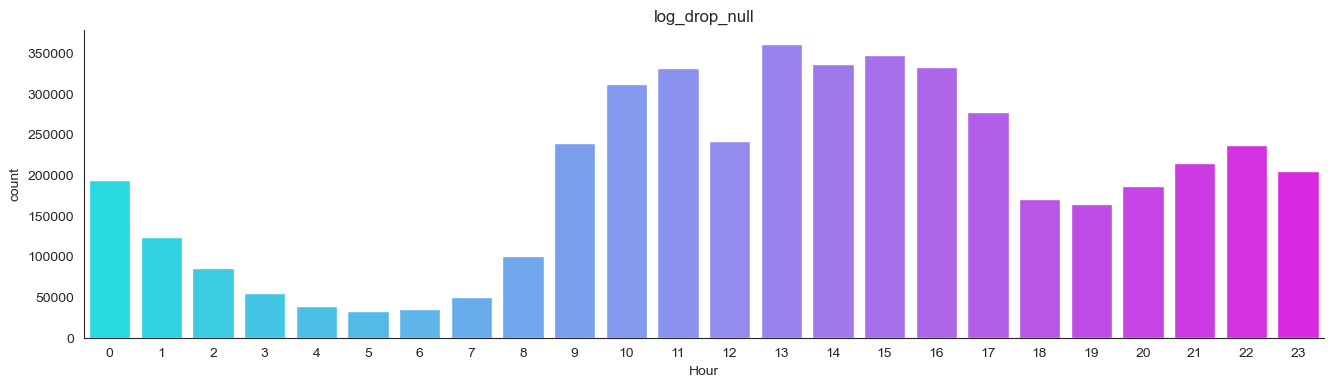

In [12]:
# 그래프표현 수치표현
# 그래프도 나와야하지만 비중데이터도 같이 보여줘야함

# text  = 제목 : 시간대별 로그데이터

plt.figure(figsize=(16, 4))
display(log_drop_null["Hour"].value_counts(normalize=True))
sns.countplot(data=log_drop_null, x="Hour", palette='cool')
# sns.set_palette('Paired', 9)
plt.title('log_drop_null')
plt.xticks()
sns.despine()

15    0.083965
14    0.081647
13    0.081536
11    0.080453
16    0.078377
10    0.070698
17    0.061447
12    0.061088
9     0.043931
21    0.042579
22    0.041862
23    0.040144
20    0.037819
0     0.036087
18    0.035611
19    0.033749
1     0.023545
2     0.016757
8     0.016253
3     0.010576
4     0.006271
7     0.005747
5     0.005416
6     0.004443
Name: Hour, dtype: float64

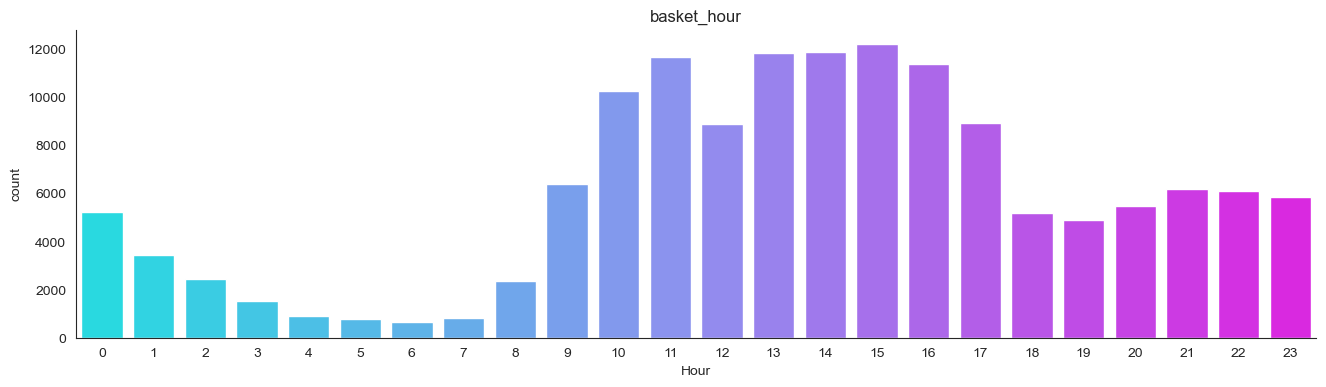

In [13]:
plt.figure(figsize=(16, 4))
display(basket_hour["Hour"].value_counts(normalize=True))
sns.countplot(data=basket_hour, x="Hour", palette='cool')
plt.title('basket_hour')
plt.xticks()
sns.despine()

13    0.077019
15    0.074075
14    0.071669
16    0.071004
11    0.070580
10    0.066706
17    0.059240
9     0.051458
12    0.051425
22    0.050899
21    0.046065
23    0.043929
0     0.041723
20    0.040050
18    0.036628
19    0.035160
1     0.026488
8     0.021535
2     0.018486
3     0.011816
7     0.010834
4     0.008375
6     0.007642
5     0.007193
Name: Hour, dtype: float64

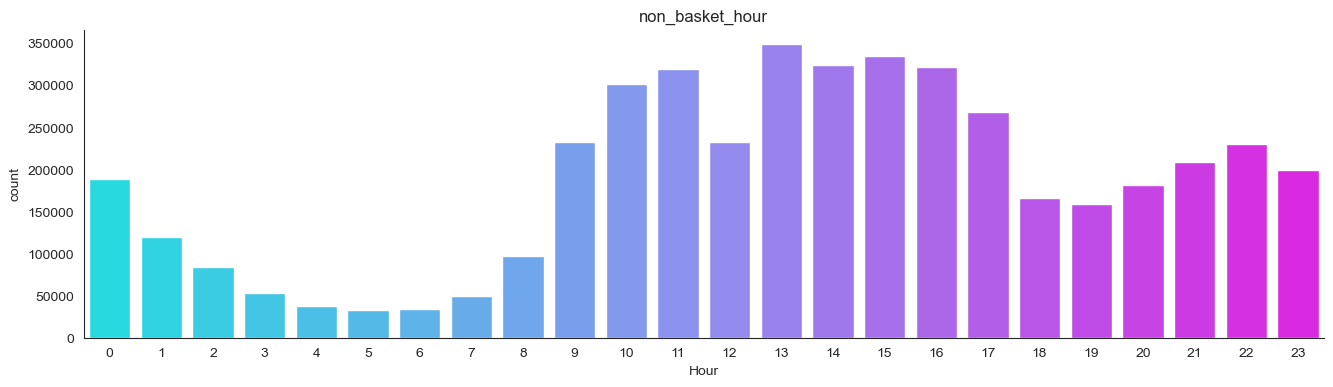

In [14]:
plt.figure(figsize=(16, 4))
display(non_basket_hour["Hour"].value_counts(normalize=True))
sns.countplot(data=non_basket_hour, x="Hour", palette='cool')
plt.title('non_basket_hour')
plt.xticks()
sns.despine()

Windows      6.522892e-01
Android      1.756621e-01
iOS          1.119223e-01
Mac OS X     5.765672e-02
Linux        1.858465e-03
Chrome OS    2.363489e-04
Other        2.301405e-04
CentOS       6.315483e-05
Ubuntu       4.602810e-05
Tizen        3.425347e-05
FreeBSD      6.422525e-07
Fedora       4.281683e-07
OpenBSD      2.140842e-07
Name: useragent_os, dtype: float64

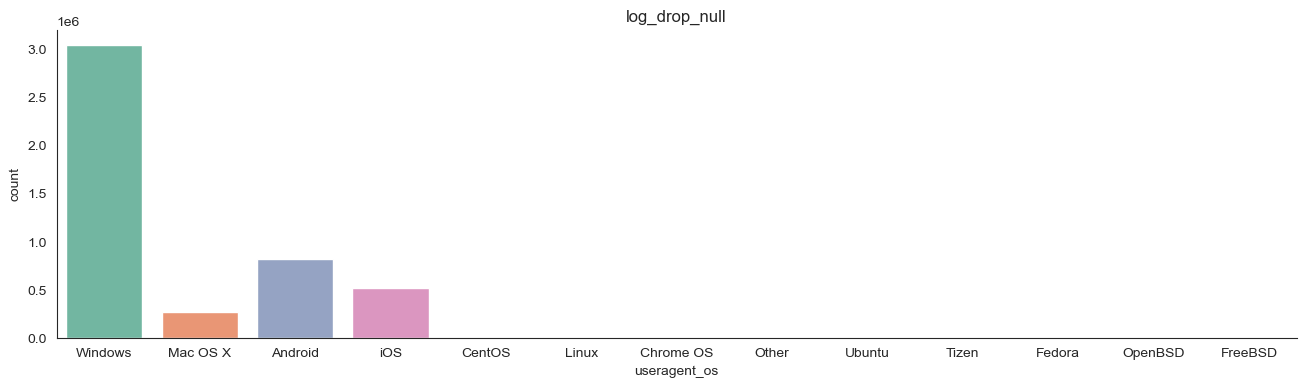

In [15]:
# 그래프표현 수치표현
# 그래프도 나와야하지만 비중데이터도 같이 보여줘야함
# 전체 데이터 os 비중, 전체시간, 근무시간과, 자는시간 

# text = 제목 : 전체 데이터 시간대별  OS 비중

plt.figure(figsize=(16, 4))
display(log_drop_null["useragent_os"].value_counts(normalize=True))
sns.countplot(data=log_drop_null, x="useragent_os", palette='Set2')
plt.title('log_drop_null')
plt.xticks()
sns.despine()

Windows      7.674684e-01
Android      1.117415e-01
iOS          7.020231e-02
Mac OS X     4.871286e-02
Linux        1.468055e-03
Chrome OS    1.961608e-04
Other        1.106851e-04
CentOS       3.820802e-05
Ubuntu       3.545074e-05
Tizen        2.520942e-05
Fedora       7.877942e-07
FreeBSD      3.938971e-07
Name: useragent_os, dtype: float64

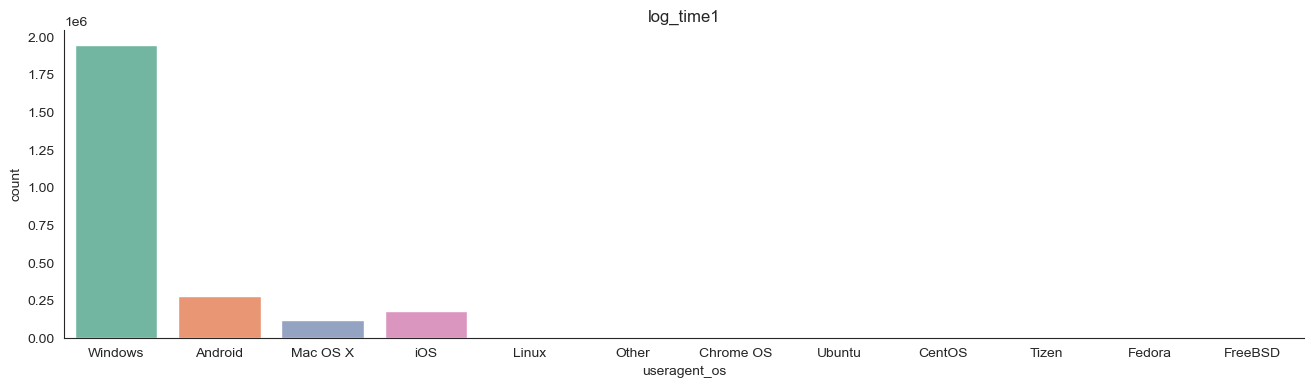

In [16]:
plt.figure(figsize=(16, 4))
display(log_time1["useragent_os"].value_counts(normalize=True))
sns.countplot(data=log_time1, x="useragent_os", palette='Set2')
plt.title('log_time1')
plt.xticks()
sns.despine()

Windows      0.474668
Android      0.270808
iOS          0.171572
Mac OS X     0.079242
Linux        0.003115
Chrome OS    0.000220
Other        0.000172
Ubuntu       0.000096
Tizen        0.000055
CentOS       0.000052
Name: useragent_os, dtype: float64

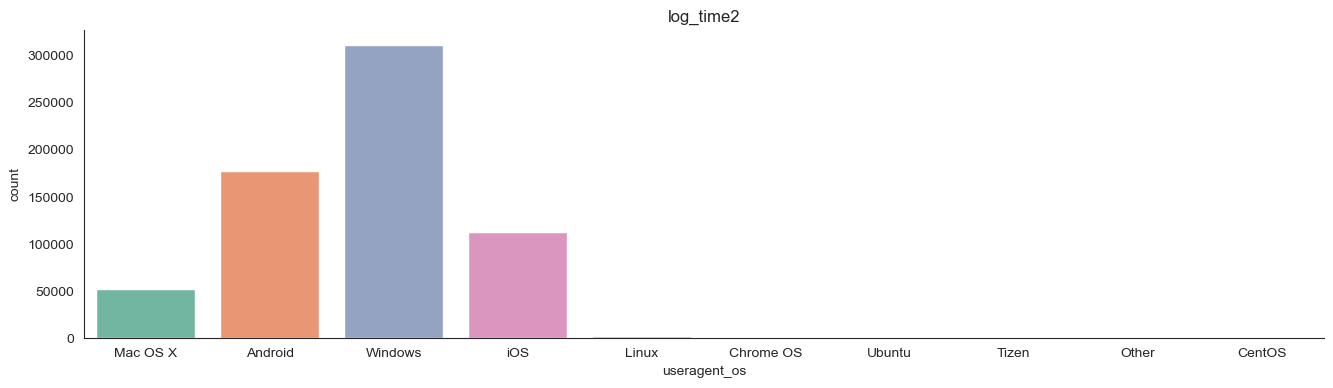

In [17]:
plt.figure(figsize=(16, 4))
display(log_time2["useragent_os"].value_counts(normalize=True))
sns.countplot(data=log_time2, x="useragent_os", palette='Set2')
plt.title('log_time2')
plt.xticks()
sns.despine()

Windows      0.899954
Mac OS X     0.092167
iOS          0.004001
Linux        0.002256
Android      0.001187
Chrome OS    0.000414
Ubuntu       0.000014
Tizen        0.000007
Name: useragent_os, dtype: float64

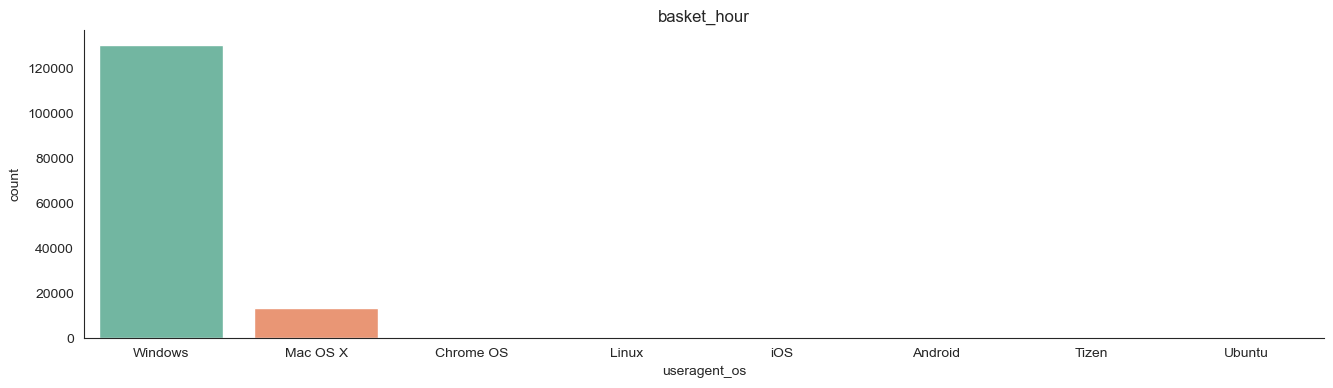

In [18]:
# 그래프표현 수치표현
# 그래프도 나와야하지만 비중데이터도 같이 보여줘야함
# 바스켓 uid os 비중, 전체시간, 근무시간과, 자는시간 

# text  = 제목 : Basket Uid Data 시간대별 OS 비율

plt.figure(figsize=(16, 4))
display(basket_hour["useragent_os"].value_counts(normalize=True))
sns.countplot(data=basket_hour, x="useragent_os", palette='Set2')
plt.title('basket_hour')
plt.xticks()
sns.despine()

Windows      0.925649
Mac OS X     0.070080
iOS          0.002084
Linux        0.001209
Android      0.000863
Chrome OS    0.000115
Name: useragent_os, dtype: float64

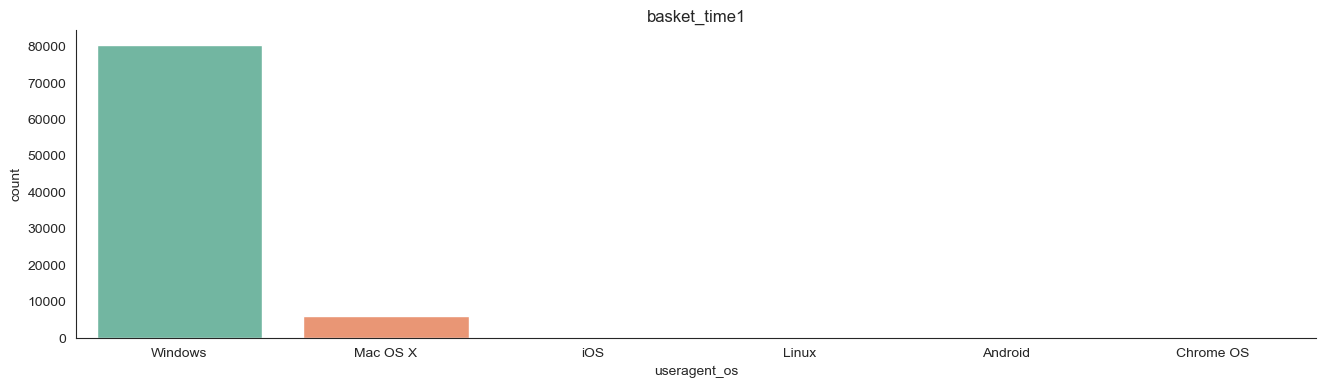

In [19]:
plt.figure(figsize=(16, 4))
display(basket_time1["useragent_os"].value_counts(normalize=True))
sns.countplot(data=basket_time1, x="useragent_os", palette='Set2')
plt.title('basket_time1')
plt.xticks()
sns.despine()

Windows      0.844676
Mac OS X     0.136552
iOS          0.008638
Linux        0.007309
Android      0.002160
Chrome OS    0.000498
Ubuntu       0.000111
Tizen        0.000055
Name: useragent_os, dtype: float64

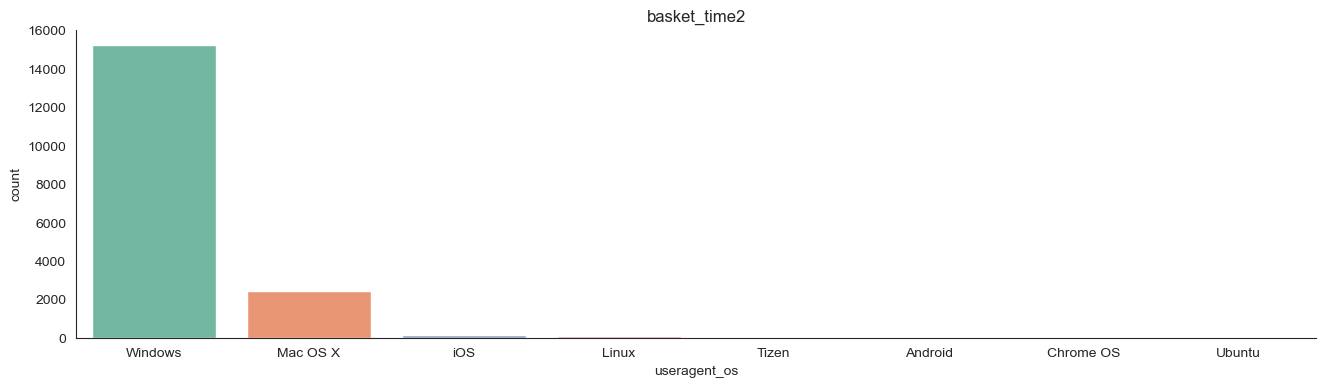

In [20]:
plt.figure(figsize=(16, 4))
display(basket_time2["useragent_os"].value_counts(normalize=True))
sns.countplot(data=basket_time2, x="useragent_os", palette='Set2')
plt.title('basket_time2')
plt.xticks()
sns.despine()

Windows      6.443574e-01
Android      1.812498e-01
iOS          1.153786e-01
Mac OS X     5.655148e-02
Linux        1.845737e-03
Other        2.375110e-04
Chrome OS    2.306619e-04
CentOS       6.517744e-05
Ubuntu       4.706032e-05
Tizen        3.512954e-05
FreeBSD      6.628214e-07
Fedora       4.418809e-07
OpenBSD      2.209405e-07
Name: useragent_os, dtype: float64

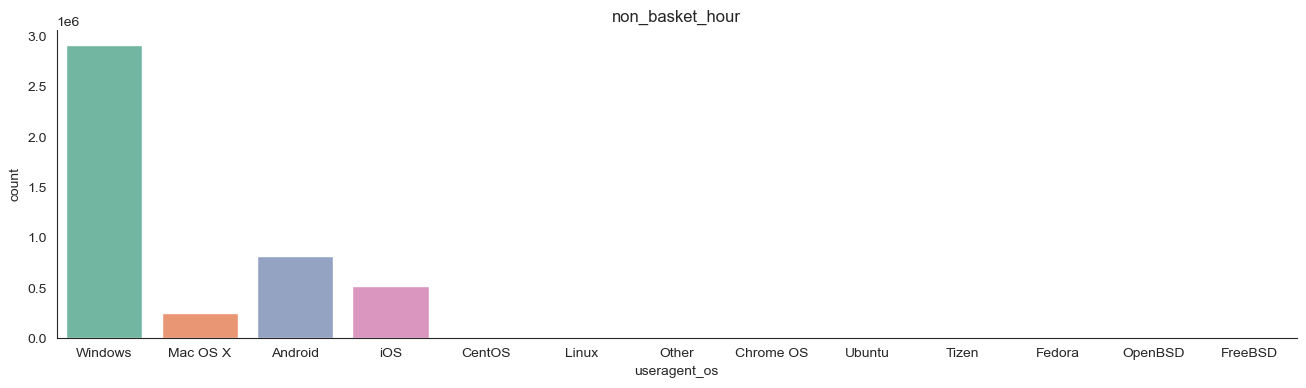

In [21]:
# 그래프표현 수치표현
# 그래프도 나와야하지만 비중데이터도 같이 보여줘야함
# non 바스켓 uid os 비중, 전체시간, 근무시간과, 자는시간 


# text  = 제목 :  Non Basket Uid Data 시간대별 OS 비율

plt.figure(figsize=(16, 4))
display(non_basket_hour["useragent_os"].value_counts(normalize=True))
sns.countplot(data=non_basket_hour, x="useragent_os", palette='Set2')
plt.title('non_basket_hour')
plt.xticks()
sns.despine()

Windows      7.618648e-01
Android      1.156694e-01
iOS          7.261542e-02
Mac OS X     4.795593e-02
Linux        1.477236e-03
Chrome OS    1.990313e-04
Other        1.146061e-04
CentOS       3.956154e-05
Ubuntu       3.670659e-05
Tizen        2.610246e-05
Fedora       8.157019e-07
FreeBSD      4.078510e-07
Name: useragent_os, dtype: float64

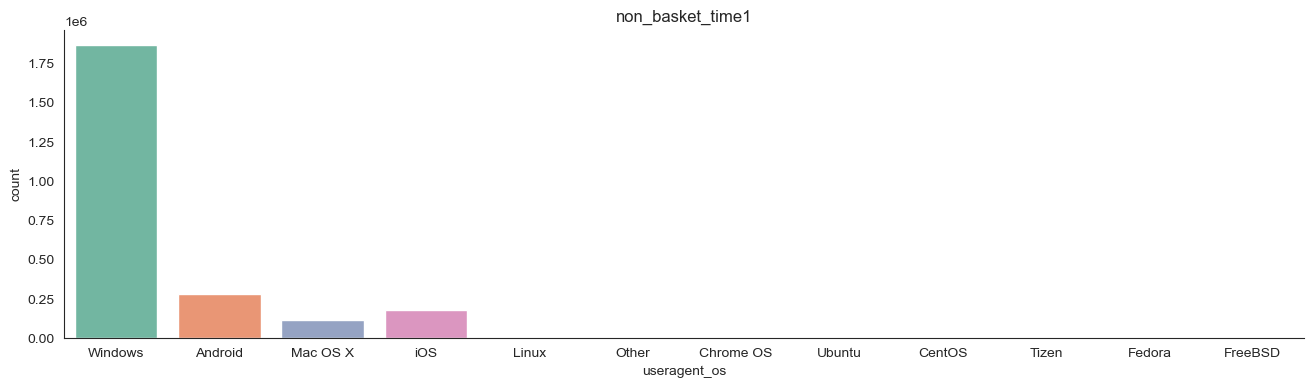

In [22]:
plt.figure(figsize=(16, 4))
display(non_basket_time1["useragent_os"].value_counts(normalize=True))
sns.countplot(data=non_basket_time1, x="useragent_os", palette='Set2')
plt.title('non_basket_time1')
plt.xticks()
sns.despine()

Windows      0.464189
Android      0.278416
iOS          0.176186
Mac OS X     0.077619
Linux        0.002997
Chrome OS    0.000212
Other        0.000177
Ubuntu       0.000096
Tizen        0.000055
CentOS       0.000053
Name: useragent_os, dtype: float64

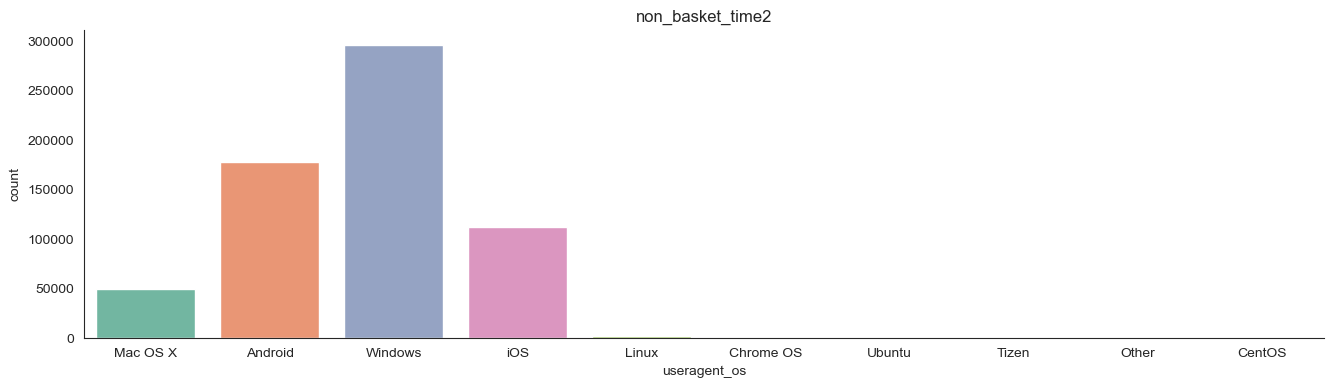

In [23]:
plt.figure(figsize=(16, 4))
display(non_basket_time2["useragent_os"].value_counts(normalize=True))
sns.countplot(data=non_basket_time2, x="useragent_os", palette='Set2')
plt.title('non_basket_time2')
plt.xticks()
sns.despine()

In [24]:
log_view_time = log_drop_null.loc[log_drop_null["viewtime"] > 0]
log_view_time['viewtime'].median() / 1000

17.985

In [25]:
log_view_time["time"] = np.where((log_view_time['Hour'] >= 10)&(log_view_time["Hour"].values <= 17) , "1","0" )

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\448817480.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
# 수치표현
# 전체 로그데이터 근무시간대 뷰타임 중간값

# text = 전체 데이터 주요(근무)시간대 viewtime 중간값
log_view_time_1 = log_view_time.loc[log_view_time["time"] == "1"]
log_view_time_1['viewtime'].median() / 1000

17.004

In [27]:
# 수치표현

# text = 전체 데이터 자는 시간대 viewtime 중간값
log_view_time_0 = log_view_time.loc[log_view_time["time"] == "0"]
log_view_time_0['viewtime'].median() / 1000

18.167

-----

In [28]:
# bidding 날짜 datetime으로 만들기
def _trans_date_time(bidding):
    bidding.index = pd.to_datetime(bidding['date'], format='%Y%m%d')
    bidding.drop('date', axis=1, inplace=True)
    return bidding

_trans_date_time(bidding)

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4
date,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.000000,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸
2022-10-31,3575637,6,0,0.0,3.333333,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2022-10-31,4129259,7,0,0.0,8.000000,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파
2022-10-31,4131479,36,3,150.0,4.416667,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,NaN
2022-10-31,4131482,224,0,0.0,5.696429,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.200000,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2023-01-03,2566880,3,0,0.0,17.000000,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품
2023-01-03,2566881,1,0,0.0,8.000000,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,NaN


In [29]:
bidding_drop_null = bidding.copy()
bidding_drop_null['Category Name 4'].fillna('null_cat4', inplace = True)
bidding_drop_null.dropna(axis = 0, inplace = True)

In [30]:
bid_data_click = bidding_drop_null[bidding_drop_null['Click'] != 0]

In [31]:
bid_data_click["Year"] = bid_data_click.index.year 
bid_data_click["Quarter"] = bid_data_click.index.quarter
bid_data_click["Month"] = bid_data_click.index.month
bid_data_click["Week"] = bid_data_click.index.week
bid_data_click["Weekday"] = bid_data_click.index.weekday
bid_data_click["Day"] = bid_data_click.index.day
bid_data_click["Dayofyear"] = bid_data_click.index.dayofyear
bid_data_click["Date"] = pd.DatetimeIndex(bid_data_click.index).date

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\2055812707.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\2055812707.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\2055812707.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [32]:
date_list = list(set(bid_data_click['Date']))              
columns = ['ds', 'y']
bid_click_mean = pd.DataFrame(columns=columns)
for date in date_list:
    bid_mean = bid_data_click.loc[bid_data_click['Date'] == date]
    bid_click_mean = bid_click_mean.append(pd.DataFrame([[date, bid_mean['Click'].mean()]], columns=columns), ignore_index=True)
bid_click_mean

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\2543848358.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\2543848358.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\2543848358.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\2543848358.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\2543848358.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\2543848358.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\2543848358.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\2543848358.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\2543848358.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\2543848358.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

,ds,y
0,2022-11-25,2.817346
1,2022-12-30,2.223400
2,2022-11-28,2.797189
3,2023-01-02,2.840578
4,2022-11-04,2.911805
5,2022-12-10,2.541355
6,2022-11-13,3.029222
7,2022-12-15,2.849268
8,2022-11-08,3.289423
9,2022-12-11,2.752205


In [33]:
train = bid_click_mean

In [34]:
prophet = Prophet()
prophet.fit(train)


# create a future data frame 
future = prophet.make_future_dataframe(periods=7, freq = 'D')
forecast = prophet.predict(future)

23:19:19 - cmdstanpy - INFO - Chain [1] start processing
23:19:19 - cmdstanpy - INFO - Chain [1] done processing


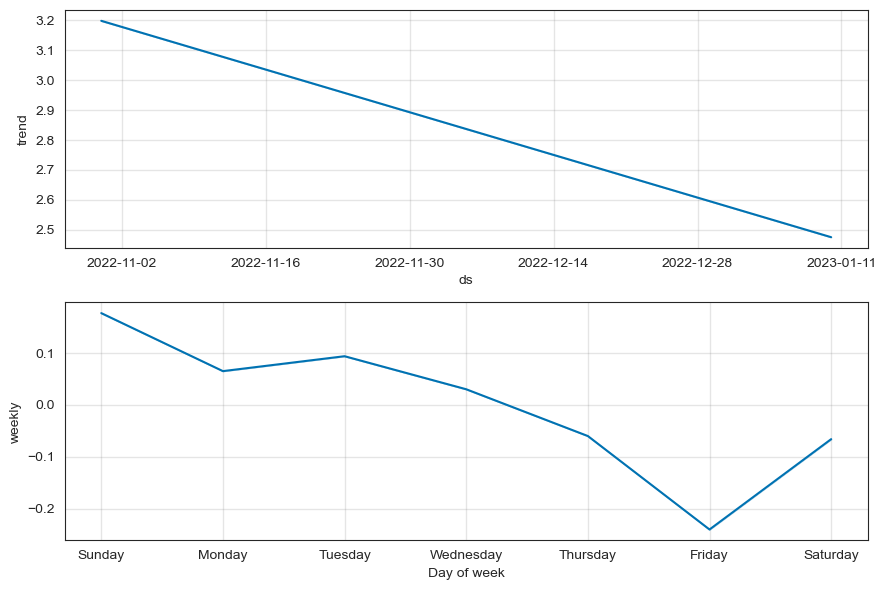

In [35]:
# 그래프 표현
# 클릭이 무슨요일의 많이 나타나는지 보여주는 용도

# text = 요일별 클릭
fig2 = prophet.plot_components(forecast)
plt.show()

---------------------------------------

In [36]:
# 바스켓을 한 uid 개수
log_uid_set = log_drop_null.loc[log_drop_null['action_type'] == 'Basket', 'uid']
log_uid_set = list(set(log_uid_set.to_list()))

basket_uid = log_drop_null[log_drop_null['uid'].isin(log_uid_set)]

In [37]:
basket_viewtime = basket_uid.loc[basket_uid["viewtime"] > 0]
basket_viewtime.viewtime.median() / 1000

18.017

In [39]:
basket_uid[basket_uid['useragent_os'].str.contains('Windows|Android|iOS|Mac OS X')]

basket_uid["useragent_os"] = np.where((basket_uid['useragent_os'] == 'Android')|(basket_uid["useragent_os"] == 'iOS') , "1","0" )

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\3219495011.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
# 수치표현
# 바스켓 uid 모바일 데이터 뷰타임 중간값

# text = Basket Uid  Mobile Data Viewtime 중간값
basket_mobile = basket_uid[basket_uid['useragent_os'] == '1']
basket_mobile = basket_mobile[basket_mobile['viewtime'] > 0]
basket_mobile.viewtime.median() / 1000

14.008

In [41]:
# 수치표현
# 바스켓 uid 데스크탑 데이터 중간값

# text = Basket Uid Desktop Viewtime 중간값
basket_desktop = basket_uid[basket_uid['useragent_os'] == '0']
basket_desktop = basket_desktop[basket_desktop['viewtime'] > 0]
basket_desktop.viewtime.median() / 1000

18.018

In [65]:
# 수치표현
cat_10 = list(basket_mobile['category1'].value_counts()[:10].index)
cat_10

for i in cat_10:
    print(i)
    print(len(basket_mobile[basket_mobile['category1'] == i]) / len(basket_mobile))

가구
0.349145842157278
가전·디지털
0.1345475081180291
패브릭
0.09685161654666102
주방용품
0.07990964280672032
데코·식물
0.06395595086827616
수납·정리
0.06268530283778061
조명
0.04630806155583792
노하우
0.04404913172384583
생활용품
0.029789637159395737
유아·아동
0.020895100945926868


In [66]:
# 수치표현
cat_10 = list(basket_desktop['category1'].value_counts()[:10].index)
cat_10

for i in cat_10:
    print(i)
    print(len(basket_desktop[basket_desktop['category1'] == i]) / len(basket_desktop))

가구
0.350666611797895
패브릭
0.13378903599362238
주방용품
0.1265498603910801
데코·식물
0.07974300401271671
수납·정리
0.06172561703290112
가전·디지털
0.051949052594344375
생활용품
0.04652317315446114
조명
0.028184453633990855
노하우
0.017675040867019987
공구·DIY
0.01683712467790134


---------------------------------------

In [44]:
non_uid_set = log_drop_null.loc[log_drop_null['action_type'] != 'Basket', 'uid']
non_uid_set = list(set(non_uid_set.to_list()))
non_basket_uid = log_drop_null[log_drop_null['uid'].isin(non_uid_set)]

In [45]:
non_basket_viewtime = non_basket_uid.loc[non_basket_uid["viewtime"] > 0]
non_basket_viewtime.viewtime.median() / 1000

17.985

In [46]:
non_basket_uid[non_basket_uid['useragent_os'].str.contains('Windows|Android|iOS|Mac OS X')]

,Unnamed: 0,uid,action_type,category1,category2,category3,geoip_city_name,useragent_os,viewrate,viewtime,Hour,Minute,time_1,time_2
collect_time,,,,,,,,,,,,,,
2022-12-29 17:29:02,0,avpKyWMn/xEADNlb,View,주방용품,그릇·홈세트,식판·나눔접시,Seongnam-si,Windows,100.0,80033,17,29,1,0
2022-12-29 12:56:38,1,0+5vEmGkOuAAB5j2,Basket,패브릭,매트,주방·다용도매트,Yongin-si,Windows,0.0,0,12,56,1,0
2022-12-29 17:54:30,3,dC9Fl2Ly9lcADrTn,Highlight,데코·식물,플라워·식물,화병·화분,Gwangmyeong-si,Windows,0.0,0,17,54,1,0
2022-12-29 18:45:05,4,09gKcGLg0I8ACyQy,View,가구,진열장·책장,책장,Jongno-gu,Mac OS X,100.0,1238,18,45,0,0
2022-12-29 17:53:11,5,091fXGIDYFEABcpA,Basket,수납·정리,화장대·테이블정리,티슈커버·케이스,Incheon,Windows,0.0,0,17,53,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29 12:45:14,5659533,3yfy5mOZpbYAAMpw,View,가전·디지털,주방가전,오븐·전자레인지,Gangnam-gu,Android,100.0,6054,12,45,1,0
2022-12-28 15:40:29,5659534,qE73wWOr1C8ABhBw,View,캠핑용품,캠핑생활용품,기타캠핑생활용품,Songpa-gu,Windows,100.0,10006,15,40,1,0
2022-12-28 14:30:09,5659537,PVMstmNg4I4ADq9R,Basket,가구,진열장·책장,책장,Jinju,Windows,0.0,0,14,30,1,0


In [47]:
non_basket_uid["useragent_os"] = np.where((non_basket_uid['useragent_os'] == 'Android')|(non_basket_uid["useragent_os"] == 'iOS') , "1","0" )

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\3357319109.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
# 수치표현
# non 바스켓 uid 데이터 모바일 중간값

# text = Non Basket Uid Mobile Data Viewtime 중간값
non_basket_mobile = non_basket_uid[non_basket_uid['useragent_os'] == '1']
non_basket_mobile = non_basket_mobile[non_basket_mobile['viewtime'] > 0]
non_basket_mobile.viewtime.median() / 1000

18.008

In [49]:
# 수치표현
# non 바스켓 uid 데이터 데스크탑 중간값

# text = Non Basket Uid Desktop Data Viewtime 중간값
non_basket_desktop = non_basket_uid[non_basket_uid['useragent_os'] == '0']
non_basket_desktop = non_basket_desktop[non_basket_desktop['viewtime'] > 0]
non_basket_desktop.viewtime.median() / 1000

17.432

In [52]:
# 수치표현
# P-value 0.05보다 작으면 두집단간의 차이가 있다. 0.05보다 크면 두집간간의 유의미한 차이가 없다

# 모바일과 데스크탑중 바스켓의 비율

log_drop_null = log_drop_null[log_drop_null['useragent_os'].str.contains('Windows|Android|iOS|Mac OS X')]
# 윈도우, 안드로이드, ios, mac 만 남기고 나머지 drop


log_drop_null["useragent_os"] = np.where((log_drop_null['useragent_os'] == 'Android')|
                                         (log_drop_null["useragent_os"] == 'iOS') , "1","0" )

# 모바일 (안드로이드, ios)은 1, 나머지는 0


log_drop_null["viewrate"] = np.where((log_drop_null['viewrate'] != 0), "1","0" )

# 뷰레이트는 혹시나해서?


log_basket = log_drop_null[log_drop_null['useragent_os']=='0'][['viewrate']]
log_non_basket = log_drop_null[log_drop_null['useragent_os']=='1'][['viewrate']]
# log_basket = log_drop_null[log_drop_null['useragent_os']=='0']
# log_non_basket = log_drop_null[log_drop_null['useragent_os']=='1']

total_basket = pd.concat([pd.get_dummies(log_basket),
                          log_drop_null[log_drop_null['useragent_os']=='0']
                          [['action_type']]],axis=1)

total_non_basket = pd.concat([pd.get_dummies(log_non_basket),
                              log_drop_null[log_drop_null['useragent_os']=='1']
                              [['action_type']]],axis=1)


a_0 = total_basket[total_basket['action_type']=='Basket'].shape[0]
a_1 = total_basket[total_basket['action_type']!='Basket'].shape[0]
b_0 = total_non_basket[total_non_basket['action_type']=='Basket'].shape[0]
b_1 = total_non_basket[total_non_basket['action_type']!='Basket'].shape[0]

dataset_chi = [[a_0, a_1], [b_0, b_1]]
pval = stats.chi2_contingency(dataset_chi)[1]
print('p-value : ',pval)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\3974369826.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_8332\3974369826.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



p-value :  0.0


In [ ]:
basket_hour = log_drop_null.loc[log_drop_null['action_type'] == 'Basket']

log_drop_null['time_1'] = np.where((log_drop_null['Hour'] >= 10)&(log_drop_null["Hour"].values <= 17) , "1","0" )
log_time1 = log_drop_null.loc[log_drop_null["time_1"] == "1"]
# log_time1['useragent_os'].value_counts(normalize=True)

log_drop_null['time_2'] = np.where((log_drop_null['Hour'] >= 21) , "1","0" )
log_time2 = log_drop_null.loc[log_drop_null["time_2"] == "1"]
# log_time2['useragent_os'].value_counts(normalize=True)

basket_hour["time_1"] = np.where((basket_hour['Hour'] >= 10)&(basket_hour["Hour"].values <= 17) , "1","0" )
basket_time1 = basket_hour.loc[basket_hour["time_1"] == "1"]
# basket_time1['useragent_os'].value_counts(normalize=True)

basket_hour["time_2"] = np.where((basket_hour['Hour'] >= 21) , "1","0" )
basket_time2 = basket_hour.loc[basket_hour["time_2"] == "1"]
# basket_time2['useragent_os'].value_counts(normalize=True)

non_basket_hour = log_drop_null.loc[log_drop_null['action_type'] != 'Basket']

non_basket_hour["time_1"] = np.where((non_basket_hour['Hour'] >= 10)&(non_basket_hour["Hour"].values <= 17) , "1","0" )
non_basket_time1 = non_basket_hour.loc[non_basket_hour["time_1"] == "1"]
# non_basket_time1['useragent_os'].value_counts(normalize=True)

non_basket_hour["time_2"] = np.where((non_basket_hour['Hour'] >= 21) , "1","0" )
non_basket_time2 = non_basket_hour.loc[non_basket_hour["time_2"] == "1"]
# non_basket_time2['useragent_os'].value_counts(normalize=True)

In [54]:
basket_hour['category1'].value_counts()[:10]

가구        40197
주방용품      24064
패브릭       21861
수납·정리     12922
데코·식물     12637
생활용품      11819
가전·디지털     7533
조명         3997
공구·DIY     2993
생필품        2070
Name: category1, dtype: int64

In [59]:
print((len(basket_hour)) / len(log_drop_null))

0.03110918626022744


In [58]:
# 수치표현
cat_10 = list(basket_hour['category1'].value_counts()[:10].index)
cat_10

for i in cat_10:
    print(i)
    print((len(basket_hour[basket_hour['category1'] == i]) / len(log_drop_null['category1']==i)))

가구
0.008626846862469213
주방용품
0.005164476028023463
패브릭
0.0046916809528183565
수납·정리
0.002773244649024235
데코·식물
0.0027120796029809053
생활용품
0.002536525190126717
가전·디지털
0.0016166887433136947
조명
0.0008578129439831193
공구·DIY
0.0006423402905532839
생필품
0.0004442513870515529


# bidding

In [69]:
bidding = bidding_df.copy()

In [ ]:
# bidding 날짜 datetime으로 만들기
def _trans_date_time(bidding):
    bidding.index = pd.to_datetime(bidding['date'], format='%Y%m%d')
    bidding.drop('date', axis=1, inplace=True)
    return bidding

_trans_date_time(bidding)

In [ ]:
# CTR = 클릭률
# CPC = 클릭당 비용
# CPM = 1000회 노출당 비용
# Sum of AD rank = 반올림
bidding["CTR"] = (bidding["Click"]/bidding["Impression"]) * 100
bidding["CPC"] = (bidding["Cost"]/bidding["Click"])
bidding["CPM"] = (bidding["Click"]/bidding["Cost"])
bidding['Sum of AD rank'] = bidding['Sum of AD rank'].round(0)

In [ ]:
bidding_drop_null = bidding.copy()
bidding_drop_null['Category Name 4'].fillna('null_cat4', inplace = True)
bidding_drop_null['CPC'].fillna(0, inplace = True)
bidding_drop_null['CPM'].fillna(0, inplace = True)
bidding_drop_null.dropna(axis = 0, inplace = True)
print(bidding_drop_null.isnull().sum().sort_values(ascending=False)) # null값 퍼센트로 표현

In [ ]:
price_down_5 = bidding_drop_null[bidding_drop_null['Price(PC)'] <= 50000]

price_5_10 = bidding_drop_null[(bidding_drop_null['Price(PC)'] > 50000) & (bidding_drop_null['Price(PC)'] < 100000)]

price_10_15 = bidding_drop_null[(bidding_drop_null['Price(PC)'] > 100000) & (bidding_drop_null['Price(PC)'] < 150000)]

price_15_20 = bidding_drop_null[(bidding_drop_null['Price(PC)'] > 150000) & (bidding_drop_null['Price(PC)'] < 200000)]

price_up_20 = bidding_drop_null[bidding_drop_null['Price(PC)'] >= 200000]